In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

import os
os.chdir('/content/gdrive/MyDrive/ViralMut/')

Mounted at /content/gdrive


In [6]:
import warnings

warnings.filterwarnings('ignore')

!mkdir -p ~/.fonts
!cp arial.ttf ~/.fonts/
!fc-cache -fv

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [7]:
from matplotlib import font_manager as fm

font_dir = os.path.join(os.environ['HOME'], '.fonts')
os.makedirs(font_dir, exist_ok=True)
font_name = 'arial.ttf'
font_path = os.path.join(font_dir, font_name)
fm.fontManager.addfont(font_path)

!cp {font_name} {font_dir}

## Significantly different mutations identification

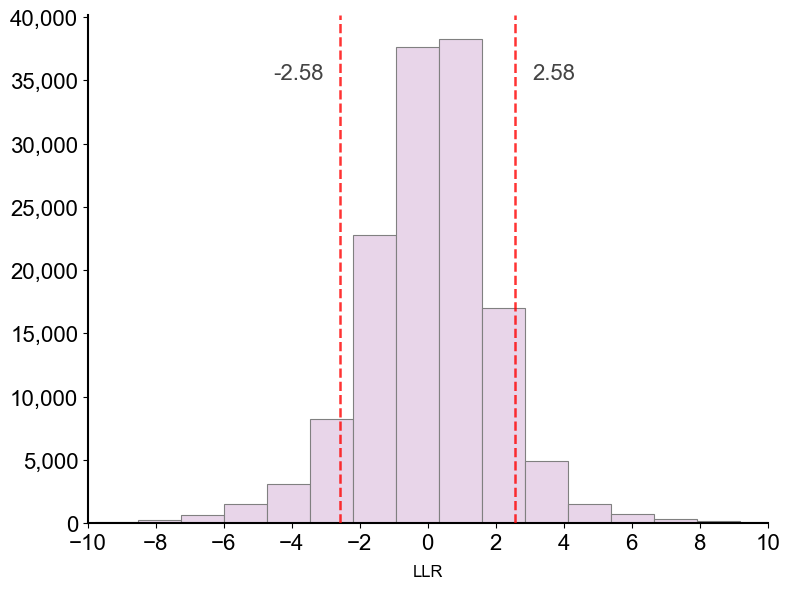

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib.ticker import FuncFormatter, MultipleLocator


alpha = 0.01
lower_critical = norm.ppf(alpha / 2)
upper_critical = norm.ppf(1 - alpha / 2)

plt.rcParams.update({
    'font.size': 10,
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 9,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.5
})

missense = pd.read_csv('alldata.csv')
fig, ax = plt.subplots(figsize=(8, 6))



n, bins, patches = ax.hist(
    missense['Diff'],
    bins=20,
    color='#E8D5E9',
    edgecolor='gray',
    linewidth=0.8,
    density=False,
    zorder=2
)


critical_kwargs = {
    'color': 'red',
    'linestyle': '--',
    'linewidth': 1.8,
    'alpha': 0.8,
    'zorder': 3
}
ax.axvline(lower_critical, **critical_kwargs)
ax.axvline(upper_critical, **critical_kwargs)


def add_critical_label(ax, x, offset):
    ax.text(
        x + offset,
        max(n) * 0.95,
        f'{x:.2f}',
        color='#444444',
        fontsize=16,
        ha='left' if x > 0 else 'right',
        va='top',
        bbox=dict(
            facecolor='white',
            edgecolor='none',
            alpha=0.8,
            boxstyle='round,pad=0.2'
        )
    )

add_critical_label(ax, lower_critical, -0.5)
add_critical_label(ax, upper_critical, +0.5)


ax.set_xlim(-10, 10)
ax.set_ylim(0, max(n) * 1.05)
ax.set_xlabel('LLR', labelpad=8)


ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: f'{int(x):,}' if x >= 1000 else str(int(x)))
)


for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)


fig.tight_layout()
plt.show()

In [11]:
pa_clm_better = missense[(missense['Diff'] > 2.58) & (missense['Label_prot'].str.contains('pathogenic'))]
be_clm_better = missense[(missense['Diff'] < -2.58) & (missense['Label_prot'].str.contains('benign'))]
CLM_better = pd.concat([pa_clm_better, be_clm_better])

In [12]:
pa_plm_better = missense[(missense['Diff'] < -2.58) & (missense['Label_prot'].str.contains('pathogenic'))]
be_plm_better = missense[(missense['Diff'] > 2.58) & (missense['Label_prot'].str.contains('benign'))]
PLM_better = pd.concat([pa_plm_better, be_plm_better])

## Missense variant preferences characterization

In [13]:
from collections import Counter
import pandas as pd

# Combine "Ref_prot" and "Mut_prot" into "Pair" for all datasets
missense['Pair'] = list(zip(missense["Ref_prot"], missense["Mut_prot"]))
CLM_better['Pair'] = list(zip(CLM_better["Ref_prot"], CLM_better["Mut_prot"]))
PLM_better['Pair'] = list(zip(PLM_better["Ref_prot"], PLM_better["Mut_prot"]))

# Count pairs in each dataset
overall_pair_counts = Counter(missense["Pair"])
clm_pair_counts = Counter(CLM_better["Pair"])
plm_pair_counts = Counter(PLM_better["Pair"])

# Total counts in each category
total_overall_count = sum(overall_pair_counts.values())
total_clm_count = sum(clm_pair_counts.values())
total_plm_count = sum(plm_pair_counts.values())

# Create unified DataFrame with all unique pairs
all_pairs = set(overall_pair_counts.keys()).union(clm_pair_counts.keys(), plm_pair_counts.keys())
pair_df = pd.DataFrame({"Pair": list(all_pairs)})

# Calculate counts and relative frequencies for each category
pair_df["Count_overall"] = pair_df["Pair"].map(overall_pair_counts).fillna(0).astype(int)
pair_df["Count_clm"] = pair_df["Pair"].map(clm_pair_counts).fillna(0).astype(int)
pair_df["Count_plm"] = pair_df["Pair"].map(plm_pair_counts).fillna(0).astype(int)

pair_df["Freq_overall"] = pair_df["Count_overall"] / total_overall_count
pair_df["Freq_clm"] = pair_df["Count_clm"] / total_clm_count
pair_df["Freq_plm"] = pair_df["Count_plm"] / total_plm_count
pair_df["BR_clm"] = pair_df["Freq_clm"]/ pair_df["Freq_overall"]
pair_df["BR_plm"] = pair_df["Freq_plm"]/ pair_df["Freq_overall"]

In [18]:
from collections import Counter
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from statsmodels.stats.multitest import multipletests


alpha = 0.01


pvals_clm, pvals_plm = [], []

for i, row in pair_df.iterrows():

    obs_clm = row["Count_clm"]
    obs_plm = row["Count_plm"]
    obs_overall = row["Count_overall"]


    expected_clm = (total_clm_count * obs_overall) / total_overall_count
    expected_plm = (total_plm_count * obs_overall) / total_overall_count


    contingency_clm = np.array([
        [obs_clm, total_clm_count - obs_clm],
        [obs_overall - obs_clm, total_overall_count - obs_overall]
    ])

    contingency_plm = np.array([
        [obs_plm, total_plm_count - obs_plm],
        [obs_overall - obs_plm, total_overall_count - obs_overall]
    ])


    _, pval_clm, _, _ = chi2_contingency(contingency_clm)
    _, pval_plm, _, _ = chi2_contingency(contingency_plm)

    pvals_clm.append(pval_clm)
    pvals_plm.append(pval_plm)


reject_clm, pvals_clm_corr, _, _ = multipletests(pvals_clm, alpha=alpha, method='fdr_bh')
reject_plm, pvals_plm_corr, _, _ = multipletests(pvals_plm, alpha=alpha, method='fdr_bh')


pair_df["pvalue_clm_raw"]       = pvals_clm
pair_df["pvalue_clm_corrected"] = pvals_clm_corr
pair_df["significant_clm"]      = reject_clm

pair_df["pvalue_plm_raw"]       = pvals_plm
pair_df["pvalue_plm_corrected"] = pvals_plm_corr
pair_df["significant_plm"]      = reject_plm

clm_enriched = pair_df[(pair_df["significant_clm"]) & (pair_df["BR_clm"] > 1)]
clm_depleted = pair_df[(pair_df["significant_clm"]) & (pair_df["BR_clm"] < 1)]


plm_enriched = pair_df[(pair_df["significant_plm"]) & (pair_df["BR_plm"] > 1)]
plm_depleted = pair_df[(pair_df["significant_plm"]) & (pair_df["BR_plm"] < 1)]

In [21]:
codon_class = {
    'M': 1, 'W':1,
    'K': 2, 'N': 2, 'Y': 2, 'F': 2, 'C': 2, 'Q': 2, 'H': 2, 'E': 2, 'D': 2,
    'I': 3,
    'T': 4, 'P': 4, 'V': 4, 'A': 4, 'G': 4,
    'R': 6, 'S': 6, 'L': 6
}

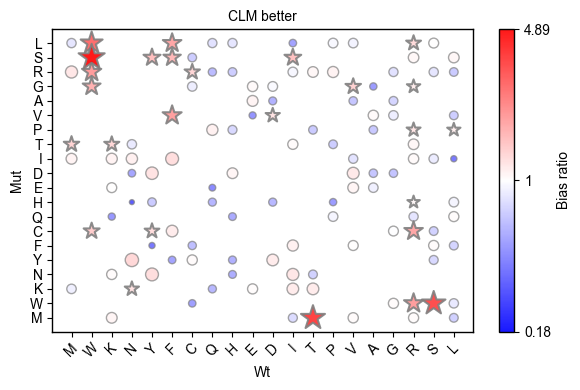

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors


pair_df[["Ref_prot", "Mut_prot"]] = pd.DataFrame(pair_df["Pair"].tolist(), index=pair_df.index)


pair_df["Ref_codon_class"] = pair_df["Ref_prot"].map(codon_class)
pair_df["Mut_codon_class"] = pair_df["Mut_prot"].map(codon_class)


df = pair_df.sort_values(by=["Ref_codon_class", "Mut_codon_class", "BR_clm"])


amino_acids_sorted = sorted(codon_class.keys(), key=lambda x: codon_class[x])
df["Ref_prot_idx"] = df["Ref_prot"].map({aa: idx for idx, aa in enumerate(amino_acids_sorted)})
df["Mut_prot_idx"] = df["Mut_prot"].map({aa: idx for idx, aa in enumerate(amino_acids_sorted)})


norm = mcolors.TwoSlopeNorm(vmin=df["BR_clm"].min(), vcenter=1, vmax=df["BR_clm"].max())
cmap = plt.cm.bwr

plt.figure(figsize=(6, 4))


df_enriched_clm = df[(df["significant_clm"]) & (df["BR_clm"] > 1)]
df_non_significant = df[~df["significant_clm"]]


plt.scatter(
    x=df_non_significant["Ref_prot_idx"],
    y=df_non_significant["Mut_prot_idx"],
    s=df_non_significant["BR_clm"] * 50,
    c=df_non_significant["BR_clm"],
    cmap=cmap,
    norm=norm,
    alpha=0.7,
    edgecolors="gray"
)


scatter_clm = plt.scatter(
    x=df_enriched_clm["Ref_prot_idx"],
    y=df_enriched_clm["Mut_prot_idx"],
    s=df_enriched_clm["BR_clm"] * 80,
    c=df_enriched_clm["BR_clm"],
    cmap=cmap,
    norm=norm,
    alpha=0.9,
    edgecolors="gray",
    linewidth=1.5,
    marker="*"
)


cbar = plt.colorbar(scatter_clm)
cbar.set_label("Bias ratio", fontsize=10)
cbar.ax.tick_params(labelsize=10)

ticks = [df["BR_clm"].min(), 1, df["BR_clm"].max()]
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{ticks[0]:.2f}", "1", f"{ticks[2]:.2f}"])

ax = plt.gca()
ax.spines["top"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)
ax.spines["left"].set_linewidth(1)
ax.spines["right"].set_linewidth(1)
cbar.outline.set_linewidth(1)


plt.xlabel("Wt", fontsize=10)
plt.ylabel("Mut", fontsize=10)
plt.title("CLM better", fontsize=10)


plt.xticks(
    ticks=range(len(amino_acids_sorted)),
    labels=amino_acids_sorted,
    rotation=45,
    fontsize=10
)
plt.yticks(
    ticks=range(len(amino_acids_sorted)),
    labels=amino_acids_sorted,
    fontsize=10
)

plt.tight_layout()
plt.show()

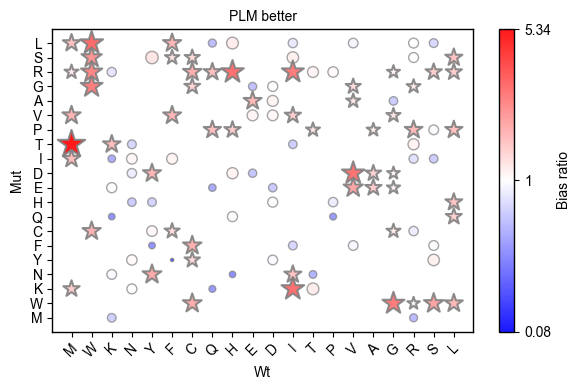

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors


pair_df[["Ref_prot", "Mut_prot"]] = pd.DataFrame(pair_df["Pair"].tolist(), index=pair_df.index)


pair_df["Ref_codon_class"] = pair_df["Ref_prot"].map(codon_class)
pair_df["Mut_codon_class"] = pair_df["Mut_prot"].map(codon_class)


df = pair_df.sort_values(by=["Ref_codon_class", "Mut_codon_class", "BR_plm"])


amino_acids_sorted = sorted(codon_class.keys(), key=lambda x: codon_class[x])
df["Ref_prot_idx"] = df["Ref_prot"].map({aa: idx for idx, aa in enumerate(amino_acids_sorted)})
df["Mut_prot_idx"] = df["Mut_prot"].map({aa: idx for idx, aa in enumerate(amino_acids_sorted)})


norm = mcolors.TwoSlopeNorm(vmin=df["BR_plm"].min(), vcenter=1, vmax=df["BR_plm"].max())
cmap = plt.cm.bwr

plt.figure(figsize=(6, 4))


df_enriched_plm = df[(df["significant_plm"]) & (df["BR_plm"] > 1)]
df_non_significant = df[~df["significant_plm"]]


plt.scatter(
    x=df_non_significant["Ref_prot_idx"],
    y=df_non_significant["Mut_prot_idx"],
    s=df_non_significant["BR_plm"] * 50,
    c=df_non_significant["BR_plm"],
    cmap=cmap,
    norm=norm,
    alpha=0.7,
    edgecolors="gray"
)


scatter_plm = plt.scatter(
    x=df_enriched_plm["Ref_prot_idx"],
    y=df_enriched_plm["Mut_prot_idx"],
    s=df_enriched_plm["BR_plm"] * 80,
    c=df_enriched_plm["BR_plm"],
    cmap=cmap,
    norm=norm,
    alpha=0.9,
    edgecolors="gray",
    linewidth=1.5,
    marker="*"
)


cbar = plt.colorbar(scatter_plm)
cbar.set_label("Bias ratio", fontsize=10)
cbar.ax.tick_params(labelsize=10)


ticks = [df["BR_plm"].min(), 1, df["BR_plm"].max()]
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{ticks[0]:.2f}", "1", f"{ticks[2]:.2f}"])


ax = plt.gca()
ax.spines["top"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)
ax.spines["left"].set_linewidth(1)
ax.spines["right"].set_linewidth(1)
cbar.outline.set_linewidth(1)


plt.xlabel("Wt", fontsize=10)
plt.ylabel("Mut", fontsize=10)
plt.title("PLM better", fontsize=10)


plt.xticks(
    ticks=range(len(amino_acids_sorted)),
    labels=amino_acids_sorted,
    rotation=45,
    fontsize=10
)
plt.yticks(
    ticks=range(len(amino_acids_sorted)),
    labels=amino_acids_sorted,
    fontsize=10
)

plt.tight_layout()
plt.show()